<a href="https://colab.research.google.com/github/thisisindrajit/Diabetic-Retinopathy/blob/main/Diabetic_Retinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## References

- [Paper 1](https://ieeexplore.ieee.org/document/6139346)

- [Paper 2](https://iopscience.iop.org/article/10.1088/1757-899X/1070/1/012049)

- [Paper 3](https://www.sciencedirect.com/science/article/pii/S2352914820302069)
- 
[Paper 4](https://www.researchgate.net/publication/241634815_Detection_and_classification_of_diabetic_retinopathy_using_retinal_images)

- [Article](https://towardsdatascience.com/blindness-detection-diabetic-retinopathy-using-deep-learning-on-eye-retina-images-baf20fcf409e)

- [Sample code](https://github.com/debayanmitra1993-data/Blindness-Detection-Diabetic-Retinopathy-)

- [Link to DDR Dataset](https://drive.google.com/drive/folders/1z6tSFmxW_aNayUqVxx6h6bY4kwGzUTEC?usp=sharing)

- [Reference link for code 1](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb#scrollTo=Ea3kbMe-pGDw)

# Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports and initializations

In [2]:
import numpy as np
import pandas as pd
import imageio
import PIL #pillow
from PIL import Image
import cv2
import tensorflow as tf
import keras
import scipy
import os
import sys
import shutil
import matplotlib.pyplot as plt

from keras import models, layers, optimizers, regularizers
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout,Input,ZeroPadding2D
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential
from keras.layers.convolutional import Conv2D
from keras.layers import MaxPooling2D
from keras import regularizers
from keras import optimizers
from keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

## Variables

In [6]:
dataset_dir = "/content/drive/MyDrive/Sem 7/Project/Dataset/DDR-preprocessed-512/"
train_dir = dataset_dir + "train/"
valid_dir = dataset_dir + "valid/"

batch_size = 32
num_classes = 5

train_csv = pd.read_csv(dataset_dir + "train.csv")
valid_csv = pd.read_csv(dataset_dir + "valid.csv")

## Using Tensorflow with TPU

In [ ]:
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Modifying directories for easy processing by Keras

## Modifying Training directory

In [ ]:
# creating folders and arranging images based on target output
for i in range(len(train_csv)):
  file_name = train_csv["path"][i]
  output = train_csv["output"][i]

  original = train_dir + file_name
  target = train_dir + str(output) + '/' + file_name

  try:
    shutil.move(original,target)
  except:
    continue

## Modifying Validation directory

In [ ]:
# creating folders and arranging images based on target output
for i in range(len(valid_csv)):
  file_name = valid_csv["path"][i]
  output = valid_csv["output"][i]

  original = valid_dir + file_name
  target = valid_dir + str(output) + '/' + file_name

  try:
    shutil.move(original,target)
  except:
    continue

# Image pre-processing

In [ ]:
def crop_center(pil_img, crop_width, crop_height):
  img_width, img_height = pil_img.size
  return pil_img.crop(((img_width - crop_width) // 2,
                        (img_height - crop_height) // 2,
                        (img_width + crop_width) // 2,
                        (img_height + crop_height) // 2))

## Preprocessing training dataset

In [ ]:
for i in range(len(train_csv)):
  if (train_csv["output"][i] != 5): # 5 is ungradeable
    file_name = train_csv["path"][i]
    output = train_csv["output"][i]
    original_img = train_dir + str(output) + '/' + file_name

    img = cv2.imread(original_img)

    # converting to grayscale
    gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # applying equalize histograms function
    gray_img_eqhist=cv2.equalizeHist(gray_img)

    # creating CLAHE filter and applying
    clahe=cv2.createCLAHE(clipLimit=10)
    gray_img_clahe=clahe.apply(gray_img_eqhist)

    kernel = np.array([[0, 0, 0],
                        [0, 1, 0],
                        [0, 0, 0]])

    # sharpening the image
    sharp = cv2.filter2D(src=gray_img_clahe, ddepth=-1, kernel=kernel)

    # inverting (negating) the image 
    invimage = cv2.bitwise_not(sharp)

    preprocessed_image = Image.fromarray(invimage)  

    target_path = train_dir + str(output) + '/' + file_name

    preprocessed_image.save(target_path)

## Preprocessing validation dataset

In [ ]:
for i in range(len(valid_csv)):
  if (valid_csv["output"][i] != 5): # 5 is ungradeable
    file_name = valid_csv["path"][i]
    output = valid_csv["output"][i]
    original_img = valid_dir + str(output) + '/' + file_name

    img = cv2.imread(original_img)

    # converting to grayscale
    gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # equalizing all histograms
    gray_img_eqhist=cv2.equalizeHist(gray_img)

    # creating CLAHE filter and applying it to the equalized histogram image
    clahe=cv2.createCLAHE(clipLimit=10)
    gray_img_clahe=clahe.apply(gray_img_eqhist)

    kernel = np.array([[0, 0, 0],
                        [0, 1, 0],
                        [0, 0, 0]])

    # sharpening the image
    sharp = cv2.filter2D(src=gray_img_clahe, ddepth=-1, kernel=kernel)

    # inverting (negating) the image 
    invimage = cv2.bitwise_not(sharp)

    preprocessed_image = Image.fromarray(invimage)  

    target_path = valid_dir + str(output) + '/' + file_name

    preprocessed_image.save(target_path)

# Loading data using Keras utility

## Using ImageDataGenerator for data augmentation

In [4]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

## Loading training and validation dataset

In [7]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        # changing image size from 512*512 to 256*256
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        valid_dir,
        # changing image size from 512*512 to 256*256
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical')

Found 6260 images belonging to 5 classes.
Found 2503 images belonging to 5 classes.


## Visualizing augmented data

In [24]:
x,y = train_generator.next()

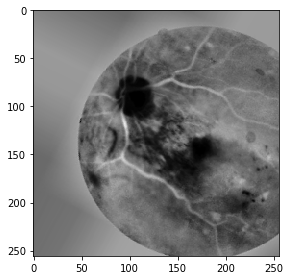

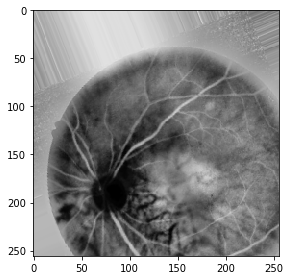

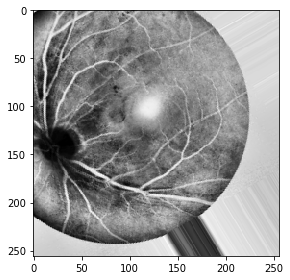

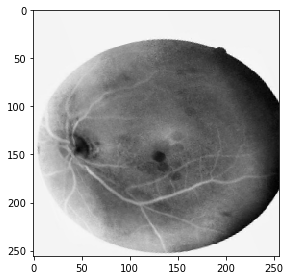

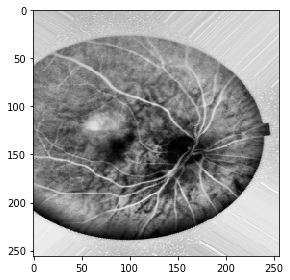

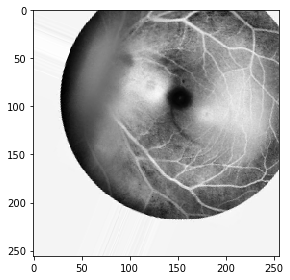

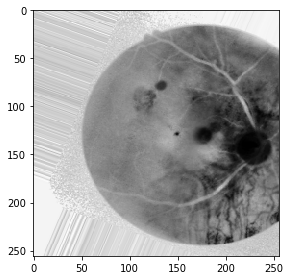

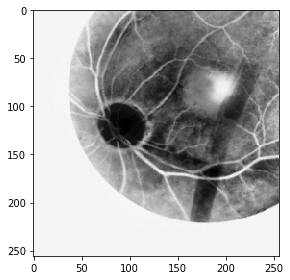

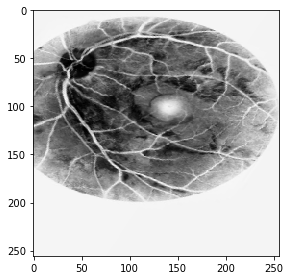

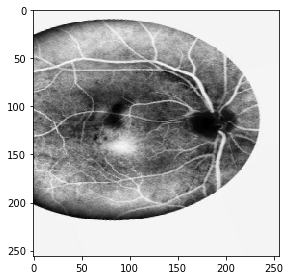

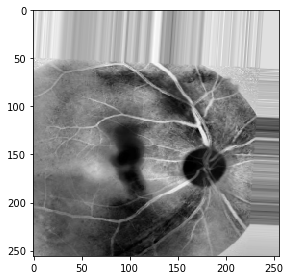

In [25]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

for i in range(0,11):
    image = x[i]
    imshow(image)

# Training a simple model

In [32]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255), # normalizing the data
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

In [33]:
learn_rate=.001
sgd=tf.keras.optimizers.SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [34]:
with tf.device('/device:GPU:0'):
  model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30
  )

Epoch 1/30
196/196 [==============================] - 2519s 13s/step - loss: 1.2152 - accuracy: 0.4978 - val_loss: 1.1309 - val_accuracy: 0.5006
Epoch 2/30
196/196 [==============================] - 157s 798ms/step - loss: 1.1342 - accuracy: 0.4970 - val_loss: 1.1444 - val_accuracy: 0.3576
Epoch 3/30
196/196 [==============================] - 153s 778ms/step - loss: 1.1341 - accuracy: 0.4981 - val_loss: 1.1380 - val_accuracy: 0.5006
Epoch 4/30
196/196 [==============================] - 155s 788ms/step - loss: 1.1344 - accuracy: 0.5005 - val_loss: 1.1353 - val_accuracy: 0.5006
Epoch 5/30
196/196 [==============================] - 153s 778ms/step - loss: 1.1324 - accuracy: 0.4990 - val_loss: 1.1313 - val_accuracy: 0.5006
Epoch 6/30
196/196 [==============================] - 149s 759ms/step - loss: 1.1325 - accuracy: 0.5005 - val_loss: 1.1305 - val_accuracy: 0.5006
Epoch 7/30
196/196 [==============================] - 148s 755ms/step - loss: 1.1335 - accuracy: 0.5005 - val_loss: 1.1310 - 

KeyboardInterrupt: ignored

In [ ]:
model.summary()

# Proposed Model

## Getting the base model (DenseNet)

In [ ]:
conv_base = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

## Creating the model

In [ ]:
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512,activation=('relu'))) 
model.add(layers.Dense(256,activation=('relu'))) 
model.add(layers.Dropout(.3))
model.add(layers.Dense(128,activation=('relu'))) 
model.add(layers.Dense(num_classes, activation='sigmoid'))

In [ ]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

Number of trainable weights before freezing the conv base: 370
Number of trainable weights after freezing the conv base: 8


In [ ]:
learn_rate=.001
sgd=tf.keras.optimizers.SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   min_delta=0.001, 
                   verbose=1, 
                   patience=40, 
                   restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              mode='min', 
                              factor=0.9, 
                              patience=15, 
                              min_lr=1e-20, 
                              verbose=1, 
                              cooldown=3)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 8, 8, 1024)        7037504   
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               33554944  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 6

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(
        train_generator,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=20, #50
        verbose=2,
        callbacks=[es, reduce_lr])

Epoch 1/30
196/196 - 1008s - loss: 1.0594 - accuracy: 0.5855 - val_loss: 0.9363 - val_accuracy: 0.6391
Epoch 2/30
196/196 - 422s - loss: 0.8993 - accuracy: 0.6538 - val_loss: 0.8016 - val_accuracy: 0.6687
Epoch 3/30
196/196 - 358s - loss: 0.8588 - accuracy: 0.6711 - val_loss: 0.7206 - val_accuracy: 0.7391
Epoch 4/30
196/196 - 291s - loss: 0.8309 - accuracy: 0.6810 - val_loss: 0.7412 - val_accuracy: 0.7484
Epoch 5/30
196/196 - 261s - loss: 0.8080 - accuracy: 0.6979 - val_loss: 0.7834 - val_accuracy: 0.7141
Epoch 6/30
196/196 - 224s - loss: 0.7956 - accuracy: 0.6936 - val_loss: 0.6557 - val_accuracy: 0.7641
Epoch 7/30
196/196 - 212s - loss: 0.7874 - accuracy: 0.6958 - val_loss: 0.6975 - val_accuracy: 0.7469
Epoch 8/30
196/196 - 194s - loss: 0.7677 - accuracy: 0.7133 - val_loss: 0.7276 - val_accuracy: 0.7328
Epoch 9/30
196/196 - 187s - loss: 0.7505 - accuracy: 0.7149 - val_loss: 0.7541 - val_accuracy: 0.7078
Epoch 10/30
196/196 - 175s - loss: 0.7629 - accuracy: 0.7120 - val_loss: 0.6581 -

In [ ]:
model.save("/content/drive/MyDrive/Sem 7/Project/models/DenseNet_256*256_TL_SGD.h5")